## Minimum spanning tree of all homes.
Read
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html
https://networkx.org/documentation/networkx-1.10/reference/introduction.html#networkx-basics

https://networkx.org/documentation/networkx-1.10/reference/algorithms.mst.html


In [1]:
import time
import networkx as nx #tree stuff
import geopandas as gp
import pandas as pd
from math import radians, sin, cos, asin, sqrt
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from shapely.geometry import LineString
from shapely.geometry import Point

In [2]:
#SET PARAMETERS FOR CLUSTERING
t0=time.perf_counter()
#Change these 
epsilon=0.2 #Min neighbour distance in km
minsamp=10 # Min cluster size 

#Don't touch these (unless you want - I'm not a cop)
epsilon=epsilon/110.54 #Convert km to degrees
minsize=minsamp #
xi=0.05 #
#maxeps=0.1

In [3]:
#LOADING HOUSEHOLD DATA

# A sample of buildings, assumed to be buildings to place in ONE distribution grid

# TODO Check you have the datafile in the same folder as this code
# Change datafile depending on sample
# I played around with a lot of samples in QGIS so if you want to do it too you can delete/add the households you want in a layer
# and save 

#buildings = 'SmallSample_OSMbuildings.geojson'
buildings = 'SLE_KenemaRadius_OSMBuildings.geojson'
#buildings = 'Kenema wo Buildings.geojson'
#buildings = 'Kenema Small Sample.geojson'
#buildings = 'thiscluster.geojson'


print('Loading data...')
# Prepare building data - read as geodataframe
gdf = gp.read_file(buildings)
# Get the number of rows (points) in the GeoDataFrame
no_points = gdf.shape[0]
gdf.head()


Loading data...


,osm_id,code,fclass,name,type,geometry
0,194636169,1500,building,None,None,"MULTIPOLYGON (((-11.36684 7.99306, -11.36680 7..."
1,194636173,1500,building,None,None,"MULTIPOLYGON (((-11.36671 7.99309, -11.36670 7..."
2,194636191,1500,building,None,None,"MULTIPOLYGON (((-11.36670 7.99296, -11.36668 7..."
3,194636195,1500,building,None,None,"MULTIPOLYGON (((-11.36686 7.99279, -11.36679 7..."
4,194636203,1500,building,None,None,"MULTIPOLYGON (((-11.36661 7.99295, -11.36657 7..."


In [4]:
# Get centroid points of building polygons - Straight from Malcolm's code

gdf['centroid'] = gdf['geometry'].centroid
# Break out lat and long into separate columns of GeoDataFrame
gdf['lon'] = gdf.centroid.x
gdf['lat'] = gdf.centroid.y
# Get lat and long columns from the GeoDataFrame and convert into a numpy array
coords = gdf.drop(['name', 'type', 'code', 'fclass', 'osm_id', 'geometry', 'centroid'], axis=1).to_numpy()
#coords = gdf.drop(['id', 'geometry', 'centroid'], axis=1).to_numpy()
# You will get a warning.

C:\Users\Admin\AppData\Local\Temp/ipykernel_36192/1760939703.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid
C:\Users\Admin\AppData\Local\Temp/ipykernel_36192/1760939703.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
C:\Users\Admin\AppData\Local\Temp/ipykernel_36192/1760939703.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Building Map


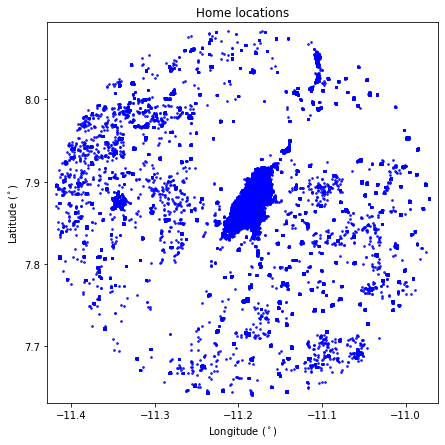

In [5]:
# Plot home locations - straight from malcolms code
plt.figure(figsize=(7, 7))
plt.title('Home locations')
plt.scatter(x=coords[:, 0], y=coords[:, 1],color='b', s=3, alpha=0.8)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
axes = plt.gca()
axes.set_xlim([min(coords[:, 0]) - 0.01, max(coords[:, 0]) + 0.01])
axes.set_ylim([min(coords[:, 1]) - 0.01, max(coords[:, 1]) + 0.01])

print("Building Map")

In [6]:
# Haversine formula for kilometer distance between two lat/long points
def haversine_dist_from_coords(lat1, lon1, lat2, lon2):
    # The math module contains a function named radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
    # calculate and return the result
    return c * r


In [7]:
#THIS IS THE FUNCTION FOR MAKING A TREE 
#Hopefully don't touch this unless you care about it more than necessary or i made mistake 

def makeatree(coords,center,j,*plot): #3 variables, coords, centroid or not (use 1 for centroids, 0 for else), and i for group nr 
    if center==0: #Plot an individual cluster
        cc=np.copy(coords[clust.labels_==j])
    else: #Plot centroids
        cc=np.copy(coords)
    no_points=cc.shape[0]
    #print('Calculating Delaunay triangulation and distance between Delaunay neighbours...')
    # Get Delauney triangulation of coordinates
    tri = Delaunay(cc)
    indices = tri.vertex_neighbor_vertices[0]
    indptr = tri.vertex_neighbor_vertices[1]
    
    cluster_avg_list = []

    # Instantiate dictionary to hold neighbors of each point & data-frame to hold distances between neighbours
    neighbors = {}
    locations = {}
    distances = pd.DataFrame(columns=["source", "dest", "distance"])

    # Get dictionary of neighbors of all points and a dictionary of locations of all points
    for k in range(0, no_points):
        neighbors[k] = indptr[indices[k]:indices[k+1]]
        locations[k] = cc[k][0], cc[k][1]

    # Get distances between all Delaunay neighbors
    for key, values in neighbors.items():
        for value in values:
            coord_1 = cc[key]
            coord_2 = cc[value]
            dist = haversine_dist_from_coords(coord_1[1], coord_1[0], coord_2[1], coord_2[0])
            distances = distances.append({"source": key, "dest": value, "distance": dist}, ignore_index=True)
            
    # Plot Delaunay triangulation - Comment out if you dont care about it 
    #plt.figure(figsize=(7, 7))
    #plt.title('Delaunay Triangulation of Homes')
    #plt.triplot(cc[:, 0], cc[:, 1], tri.simplices)
    #plt.xlabel('Longitude ($^\circ$)')
    #plt.ylabel('Latitude ($^\circ$)')
    #plt.plot(cc[:, 0], cc[:, 1], 'o')
    #axes = plt.gca()
    #axes.set_xlim([min(cc[:, 0]) - 0.001, max(cc[:, 0]) + 0.001])
    #axes.set_ylim([min(cc[:, 1]) - 0.001, max(cc[:, 1]) + 0.001])
    
    #print('Creating a graph from this information (edge weight = distance)...')
    G = nx.Graph()
    for index, row in distances.iterrows():
        G.add_edge(row['source'], row['dest'], weight=row['distance'])

    #print('Calculating the minimum spanning tree of the graph...')
    T = nx.minimum_spanning_tree(G)

    edges = T.edges(data=True)
    weights = [x[2]['weight'] for x in edges]
    total_dist = sum(weights)

    #print('Number of nodes (buildings) in the graph: ', T.number_of_nodes())
    #print('Number of edges in the minimum spanning tree: ', T.number_of_edges()) #should be n-1
    
    #print('Plotting results:')

    # Plot Minimum Spanning Tree made from Delaunay Triangulation
    if center == 1 or plot==1:
        print('Total distance of minimum spanning tree (in km): ', total_dist)
        plt.figure(figsize=(15, 15))
        labs={}
        for i in range(len(cc)):
            labs[i]=f"{i+1}"

        pos=locations
        if center==1:
            nx.draw_networkx(T, pos, with_labels=True, labels=labs, node_size=200, font_size=8, font_color="whitesmoke" )

        else:
            nx.draw_networkx(T, pos, with_labels=False, node_size=15, font_size=12)

        if center==0:
            plt.title(f'Minimum Spanning Tree of Delaunay Graph\n for cluster {j+1} \n (Edge Weight = Haversine Distance)')
        else:
            plt.title(f'Minimum Spanning Tree of Delaunay Graph\n between clusters \n (Edge Weight = Haversine Distance)')
        plt.xlabel('Longitude ($^\circ$)')
        plt.ylabel('Latitude ($^\circ$)')
        axes = plt.gca()
        axes.set_xlim([min(cc[:, 0]) - 0.01, max(cc[:, 0]) + 0.01])
        axes.set_ylim([min(cc[:, 1]) - 0.01, max(cc[:, 1]) + 0.01])
        axes.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        #axes.XTick=np.linspace(min(cc[:, 0]) - 0.001, max(cc[:, 0]) + 0.001, 12)
        #axes.YTick=np.linspace(min(cc[:, 1]) - 0.001, max(cc[:, 1]) + 0.001, 12)

        # Plot relative frequency of edge distances in minimum spanning tree
        plt.figure(figsize=(10, 4))
        plt.hist(weights, bins=200)
        plt.yscale("linear")
        plt.ylabel('Number of edges of this distance')
        plt.xlabel('Total distance (km)')

        plt.show()
        
    dfp=nx.to_pandas_edgelist(T)
        
    froms=list(range(len(dfp)))
    tos=list(range(len(dfp)))
    geos=list(range(len(dfp)))
    for i in range(len(dfp)):
        froms[i]=Point(cc[int(dfp["source"][i]),:])
        tos[i]=Point(cc[int(dfp["target"][i]),:])
        geos[i]=LineString([froms[i],tos[i]])

    gdfline=gp.GeoDataFrame(dfp,geometry=geos,crs="EPSG:4326")

    return T.number_of_nodes(), total_dist, weights, gdfline

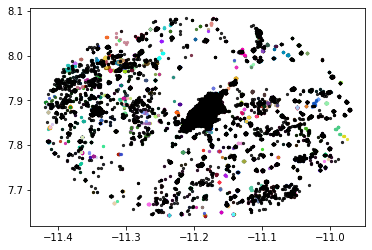

In [8]:
# CLUSTER DATA


clust = OPTICS(min_samples=minsamp, cluster_method='xi', min_cluster_size=minsize, xi=xi)

# Run the fit
clust.fit(coords)
labelsOp = clust.labels_[clust.ordering_]

# See how many houses in each cluster. cluster -1 = outlier
(unique, counts) = np.unique(labelsOp, return_counts=True)
frequencies = np.asarray((unique, counts)).T
#print(frequencies)

#plot results
# plt.figure(figsize=(7, 7))

colors = ['g', 'r', 'b', 'y', 'c','m','olive','b','m']
colors = list(range(0,len(unique)))

for i in range(len(colors)):
    colors[i]=list(np.random.choice(range(255),size=3)/255)
labels = labelsOp

for klass, color in zip(range(0, len(unique)+1), colors): #double iteration simultaneously 
    plt.scatter(x=coords[labels == klass, 0], y=coords[labels == klass, 1],color=color, s=5, alpha=0.8) #select only some points in cluster

#for klass, color in zip(range(0, 8), colors):
#    plt.scatter(x=coords[labels == klass, 0], y=coords[labels == klass, 1],color=color, s=5, alpha=0.8)

# plot outliers
plt.scatter(x=coords[clust.labels_ == -1, 0], y=coords[clust.labels_ == -1, 1],color='k', s=5, alpha=0.8)

coords_old=np.copy(coords)


Area containing of 297 clusters:


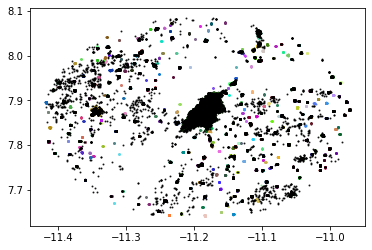

In [9]:
###### # TODO Now change range by changing eps in the DBSCAN equivalent.
## THIS WILL TAKE A WHILE 

labelsF = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=epsilon)

# See how many houses in each cluster. -1 = outlier
(unique, counts) = np.unique(labelsF, return_counts=True)
frequencies = np.asarray((unique, counts)).T
#print(frequencies)


#plt.figure(figsize=(10, 10))

#colors = ['g', 'r', 'b', 'y', 'c','m','olive','b','m']
colors = list(range(0,len(unique)))

for i in range(len(colors)):
    colors[i]=list(np.random.choice(range(255),size=3)/255)

colors=np.array(colors)

labels = labelsF
for klass, color in zip(range(0, len(unique)+1), colors): #double iteration simultaneously 
    plt.scatter(x=coords[labels == klass, 0], y=coords[labels == klass, 1],color=color, s=1, alpha=0.8) #select only some points in cluster


# plot outliers
plt.scatter(x=coords[clust.labels_ == -1, 0], y=coords[clust.labels_ == -1, 1],color='k', s=1, alpha=0.8)

df = pd.DataFrame(coords)
df['Class'] = labelsF

#Find centroid
centroid= ([[0 for x in range(2)] for y in range(klass)]) 

for i in range(klass):
    centroid[i][0]=np.average(df[df["Class"]==i][0]) #x-coordinates
    centroid[i][1]=np.average(df[df["Class"]==i][1]) #y-coordinates

    centroid=np.array(centroid)
    
#centroid[0][1]=7.819699 #substation
#centroid[0][0]=-11.180909

print(f"Area containing of {len(centroid)} clusters:")
clust.labels_=labelsF



(array([287.,   7.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.000000e+00, 2.156400e+02, 4.302800e+02, 6.449200e+02,
        8.595600e+02, 1.074200e+03, 1.288840e+03, 1.503480e+03,
        1.718120e+03, 1.932760e+03, 2.147400e+03, 2.362040e+03,
        2.576680e+03, 2.791320e+03, 3.005960e+03, 3.220600e+03,
        3.435240e+03, 3.649880e+03, 3.864520e+03, 4.079160e+03

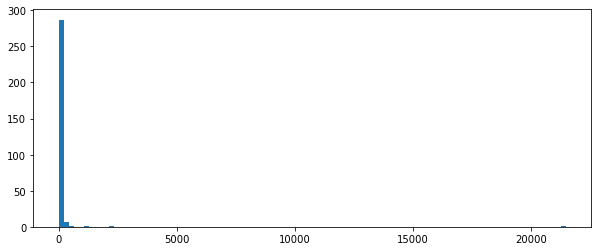

In [10]:
#PLOT HISTOGRAM OF CLUSTERS
plt.figure(figsize=(10, 4))
plt.hist(frequencies[:,1], bins=100)

#if epsilon==0.001:
    #dfeps = pd.DataFrame(data=frequencies[:,1], columns=["Frequencies"])
    #dfeps.to_csv('Frequencies01.csv')

#if epsilon==0.003:
    #dfeps = pd.DataFrame(data=frequencies[:,1], columns=["Frequencies"])
    #dfeps.to_csv('Frequencies02.csv')

#frequencies1 = pd.read_csv ('Frequencies01.csv')
#frequencies2 = pd.read_csv ('Frequencies02.csv')

#bins = np.linspace(0, 6000, 100)
#plt.bar(frequencies1["Frequencies"], bins, alpha=0.5, label='Eps=0.001')
#plt.bar(frequencies2["Frequencies"], bins, alpha=0.5, label='Eps=0.003')
#plt.legend(loc='upper right')
#plt.yscale("log")
#plt.ylabel("No of Clusters (log scale)")
#plt.xlabel("Cluster Size")
#plt.show()


Total distance of minimum spanning tree (in km):  522.4833422652478


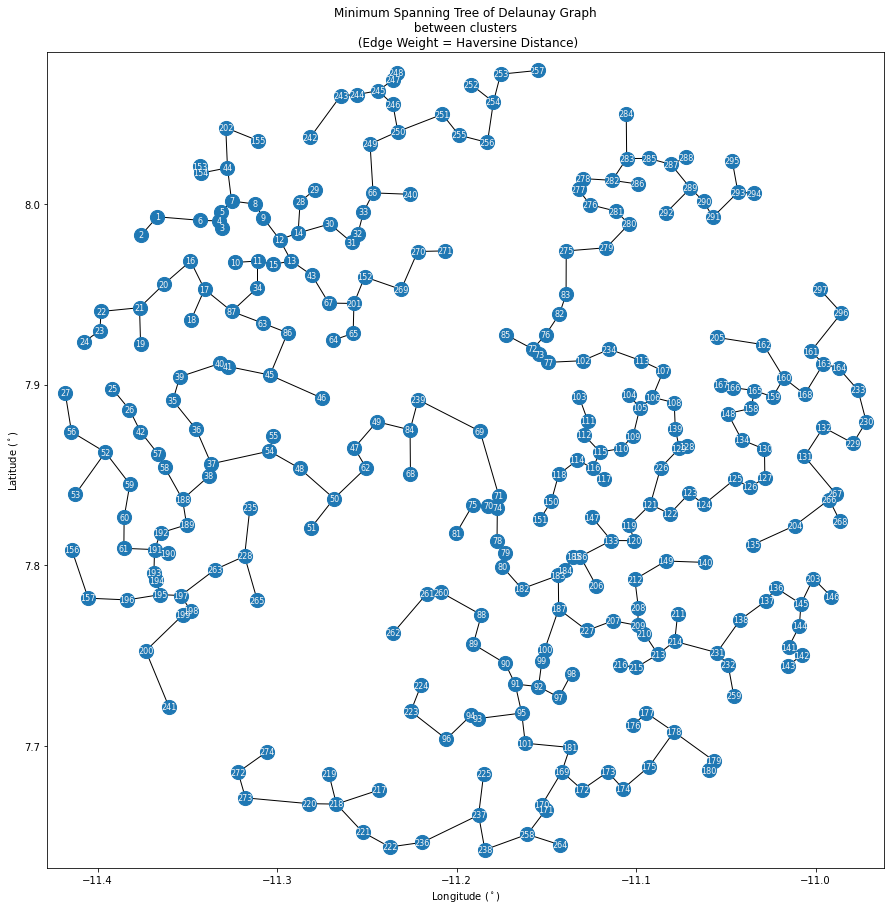

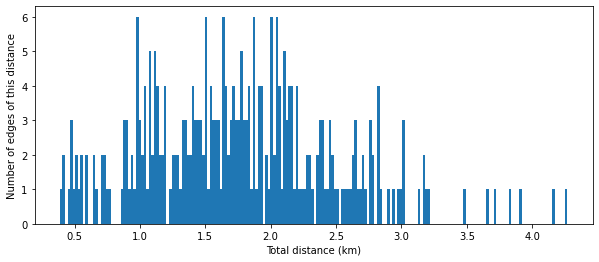

In [11]:
#Plot CENTROIDS! 

ngroups,tdists,tweight,dfp=makeatree(centroid,1,1)


In [12]:
#THIS BADBOY RETURNS FILES YOU CAN IMPORT INTO QGIS
#KenemaHH.shp gives the households colorcoded by cluster group
#KenemaPoints.shp does the same but for centroids rather than polygons

df3 = pd.DataFrame({
    "Cluster Group" : labels,
    "Latitude" : coords[:,1],
    "Longitude" : coords[:,0]
    })

gdf2 = gp.GeoDataFrame(
    df3, geometry=gp.points_from_xy(df3.Longitude, df3.Latitude), crs="EPSG:4326"
)

gdf["Label"]=labels



gdf = gdf.drop(columns=['centroid'])


gdf.to_file("KenemaHH.shp") 
gdf2.to_file("KenemaPoints.shp")



C:\Users\Admin\AppData\Local\Temp/ipykernel_36192/1692164439.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf2.to_file("KenemaPoints.shp")


In [13]:
#EXPORT THE LINES BETWEEN CLUSTERS (min_span_tree) to Lines.shp

dfp.to_file("Lines.shp")

In [14]:
#gdfline.to_file("Lines.shp")


#cluslab=list(range(len(frequencies)))

#for i in range(len(frequencies-1)):
#    cluslab[i]=f"{i+1}"

#cluslab
#plt.bar(cluslab,np.sort(frequencies[:,1]))
#plt.yscale("log")

In [ ]:
nodes=list(range(len(centroid)+2))
distances=list(range(len(centroid)+2))
names=list(range(len(centroid)+2))
weights=list(range(len(centroid)+2))

#Plot cluster info
print("Cluster Details:")
for i in range(len(centroid)):
    if 9<frequencies[i+1,1]<100000: #Put some limits cause it might take ages to run 
        print(f"Making trees... - cluster {i} has {frequencies[i,1]} nodes - {np.round(i*100/len(centroid))}%", end ="\r")
        nodes[i], distances[i],weights[i],e = makeatree(coords,0,i)
    else: 
        print(f" Making trees... - cluster {i} has {frequencies[i+1,1]} nodes so its too small or big - {np.round(i*100/len(centroid))}% \n", end ="\r")
    names[i]=f"Cluster {i+1}"
nodes[i+1]=ngroups
distances[i+1]=tdists
names[i+1]="Interclusters"
weights[i+1]=tweight

names[i+2]="Outliers"
nodes[i+2]=0
distances[i+2]="N/A"

nodes[i+2]=len(gdf)-sum(nodes)+nodes[i+1]

df2 = pd.DataFrame({
    "Nr Nodes" : nodes,
    "Total Connection Distance" : distances
    })
df2.index=names
df2

Cluster Details:


In [ ]:
t1=time.perf_counter()

print(f"The script took {t1-t0} seconds to run")
print(f"Total line distance inside clusters: {sum(distances[0:i+1])}")
print(f"Total line distance between clusters: {distances[i+1]}")

In [ ]:
#PLOT LINES FOR A SELECTED CLUSTER
cluster=3 #pick cluster

x,y,z,a=makeatree(coords,0,cluster)

a.to_file(f"Lines cluster {cluster}.shp")

### 

In [ ]:
#Send list of clusters and their sizes to csv
df2.to_csv("Cluster List.csv")


In [ ]:
#t0=time.perf_counter()
#makeatree(coords,0,68)
#t1=time.perf_counter()
#print(t1-t0)